In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [2]:
data = pd.read_csv('data/southeast.csv', index_col='index', usecols=['Data', 'Hora','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','index','station'])

In [3]:
data.head()

,Data,Hora,"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",station
index,,,,
0,2000-05-07,00:00,-9999.0,ECOLOGIA AGRICOLA
1,2000-05-07,01:00,-9999.0,ECOLOGIA AGRICOLA
2,2000-05-07,02:00,-9999.0,ECOLOGIA AGRICOLA
3,2000-05-07,03:00,-9999.0,ECOLOGIA AGRICOLA
4,2000-05-07,04:00,-9999.0,ECOLOGIA AGRICOLA


In [4]:
dataAnalyze = data[(data['station'] == 'BAURU') & (data['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']>=-10)][['Data','Hora','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']].rename({'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)':'Temp'}, axis = 1)
dataAnalyze.head()


,Data,Hora,Temp
index,,,
14,2001-08-30,14:00,35.3
19,2001-08-30,19:00,29.3
20,2001-08-30,20:00,27.9
21,2001-08-30,21:00,24.3
22,2001-08-30,22:00,23.1


In [5]:
dataAnalyze = data[(data['station'] == 'BAURU') & (data['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']>=-10)][['Data','Hora','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']].rename({'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)':'Temp'}, axis = 1)
def funConcatTime(data,hora):
    s = data + ' ' + hora
    return s
dataAnalyze['DataHora'] = dataAnalyze.apply(lambda x: funConcatTime(x.Data, x.Hora), axis = 1)
dataAnalyze.head()
dataAnalyze['DataHora'] = pd.to_datetime(dataAnalyze['DataHora'])
dataAnalyze.drop(['Data','Hora'], axis = 1, inplace=True)

In [6]:
dataAnalyze.set_index('DataHora', inplace=True)

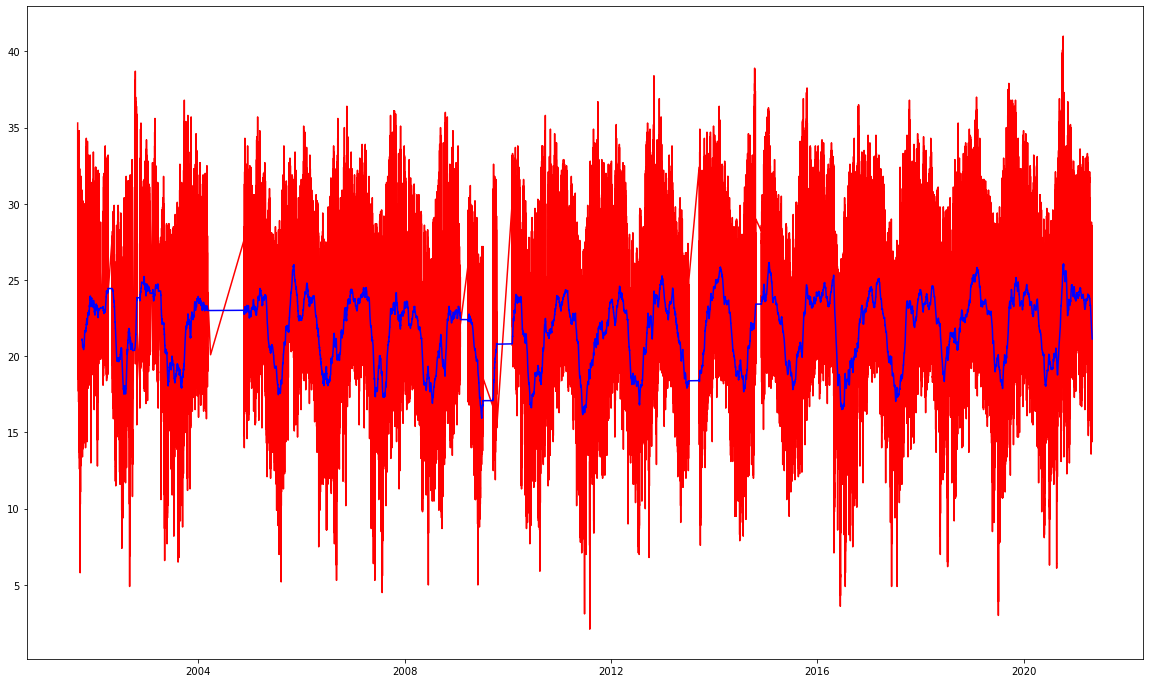

In [7]:
plt.figure(figsize = (20,12))
plt.plot(dataAnalyze, color = 'r')
plt.plot(dataAnalyze.rolling(720).mean(), color ='b')
plt.show()

In [8]:
dataAnalyze.reset_index(inplace=True)
dataAnalyze.columns = ['ds','y']
dataAnalyze.head()

,ds,y
0,2001-08-30 14:00:00,35.3
1,2001-08-30 19:00:00,29.3
2,2001-08-30 20:00:00,27.9
3,2001-08-30 21:00:00,24.3
4,2001-08-30 22:00:00,23.1


In [9]:
dataAnalyze['Year'] = dataAnalyze['ds'].dt.year

In [10]:
dataAnalyze.dtypes

ds      datetime64[ns]
y              float64
Year             int64
dtype: object

In [11]:
train = dataAnalyze[(dataAnalyze['Year'] <= 2019) & (dataAnalyze['Year']>=2007)]
test = dataAnalyze[dataAnalyze['Year'] == 2020]

In [12]:
train.shape, test.shape

((104480, 3), (8784, 3))

In [13]:
preditor = Prophet()
preditor.fit(train)

22:14:39 - cmdstanpy - INFO - Chain [1] start processing
22:15:15 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
pred = preditor.predict(test)

In [15]:
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01 00:00:00,22.707094,20.158925,27.512057,22.707094,22.707094,1.213698,1.213698,1.213698,-1.185707,...,-0.058861,-0.058861,-0.058861,2.458266,2.458266,2.458266,0.0,0.0,0.0,23.920793
1,2020-01-01 01:00:00,22.707141,20.000449,27.089360,22.707141,22.707141,0.892933,0.892933,0.892933,-1.503696,...,-0.060846,-0.060846,-0.060846,2.457475,2.457475,2.457475,0.0,0.0,0.0,23.600074
2,2020-01-01 02:00:00,22.707188,19.698620,27.201946,22.707188,22.707188,0.467564,0.467564,0.467564,-1.926237,...,-0.062871,-0.062871,-0.062871,2.456672,2.456672,2.456672,0.0,0.0,0.0,23.174751
3,2020-01-01 03:00:00,22.707234,18.989186,25.918545,22.707234,22.707234,-0.067589,-0.067589,-0.067589,-2.458530,...,-0.064917,-0.064917,-0.064917,2.455858,2.455858,2.455858,0.0,0.0,0.0,22.639645
4,2020-01-01 04:00:00,22.707281,18.380359,25.755483,22.707281,22.707281,-0.530683,-0.530683,-0.530683,-2.918752,...,-0.066963,-0.066963,-0.066963,2.455031,2.455031,2.455031,0.0,0.0,0.0,22.176597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,2020-12-31 19:00:00,23.116084,26.875691,34.686496,21.971398,24.145260,7.623711,7.623711,7.623711,5.106141,...,0.070498,0.070498,0.070498,2.447072,2.447072,2.447072,0.0,0.0,0.0,30.739795
8780,2020-12-31 20:00:00,23.116131,25.408500,32.925192,21.971162,24.145467,6.224105,6.224105,6.224105,3.700625,...,0.077350,0.077350,0.077350,2.446130,2.446130,2.446130,0.0,0.0,0.0,29.340236
8781,2020-12-31 21:00:00,23.116178,23.692529,31.539241,21.970926,24.145674,4.442246,4.442246,4.442246,1.913276,...,0.083793,0.083793,0.083793,2.445176,2.445176,2.445176,0.0,0.0,0.0,27.558423
8782,2020-12-31 22:00:00,23.116224,22.069477,29.594148,21.970690,24.145882,2.859364,2.859364,2.859364,0.325377,...,0.089775,0.089775,0.089775,2.444212,2.444212,2.444212,0.0,0.0,0.0,25.975589


In [16]:
mae = mean_absolute_error(test['y'], pred['yhat'])
rmse = np.sqrt(mean_squared_error(test['y'], pred['yhat']))
mape = mean_absolute_percentage_error(test['y'], pred['yhat'])
mae, rmse, mape

(2.496481006476901, 3.2610930862895238, 0.12591501478221537)

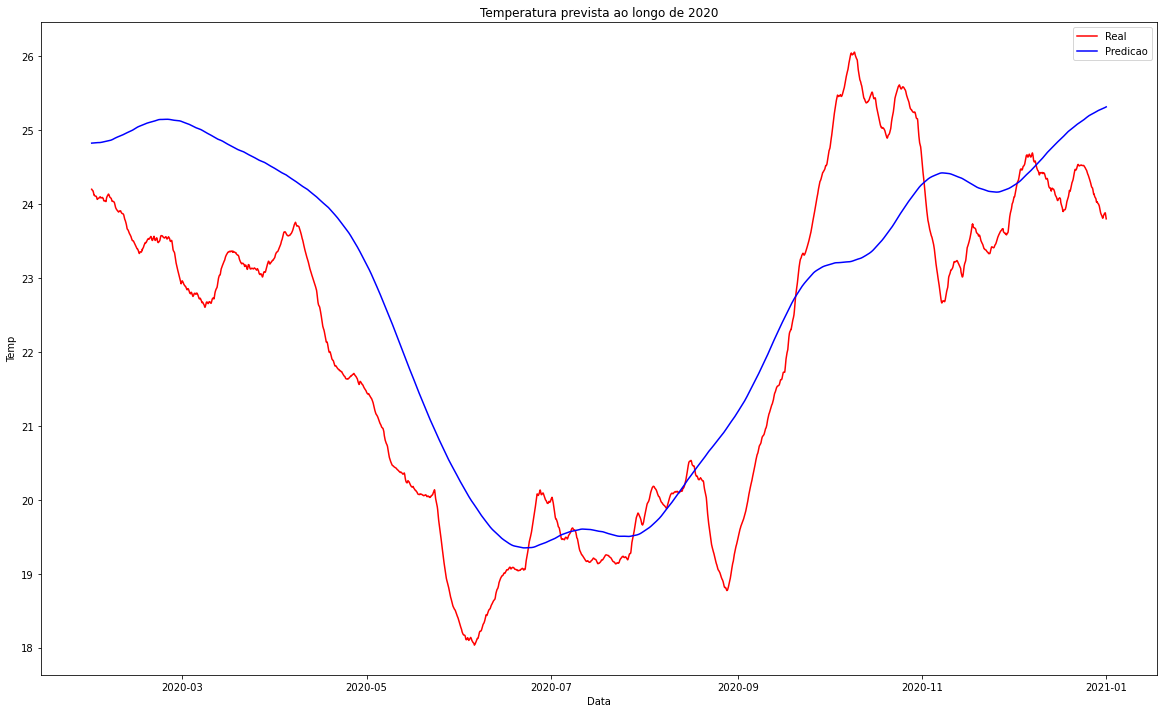

In [17]:
plt.figure(figsize=(20,12))
plt.plot(test.set_index('ds')['y'].rolling(720).mean(), color = 'r', label = 'Real')
plt.plot(pred.set_index('ds')['yhat'].rolling(720).mean(), color = 'b', label = 'Predicao')
plt.legend()
plt.ylabel('Temp')
plt.xlabel('Data')
plt.title('Temperatura prevista ao longo de 2020')
plt.show()

In [18]:
?Prophet.make_future_dataframe

Signature:
Prophet.make_future_dataframe(
    self,
    periods,
    freq='D',
    include_history=True,
)
Docstring:
Simulate the trend using the extrapolated generative model.

Parameters
----------
periods: Int number of periods to forecast forward.
freq: Any valid frequency for pd.date_range, such as 'D' or 'M'.
include_history: Boolean to include the historical dates in the data
    frame for predictions.

Returns
-------
pd.Dataframe that extends forward from the end of self.history for the
requested number of periods.
File:      ~/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py
Type:      function


In [26]:
futureDF = preditor.make_future_dataframe(periods=24*30*24, freq='H', include_history=True)
futureDF.tail()

,ds
121755,2021-12-20 19:00:00
121756,2021-12-20 20:00:00
121757,2021-12-20 21:00:00
121758,2021-12-20 22:00:00
121759,2021-12-20 23:00:00


In [27]:
predFuture = preditor.predict(futureDF)

In [29]:
predFuture

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2007-01-01 00:00:00,21.577986,19.316606,26.588396,21.577986,21.577986,1.308976,1.308976,1.308976,-1.185707,...,0.041339,0.041339,0.041339,2.453344,2.453344,2.453344,0.0,0.0,0.0,22.886961
1,2007-01-01 01:00:00,21.578106,19.098806,26.299924,21.578106,21.578106,0.989333,0.989333,0.989333,-1.503696,...,0.040546,0.040546,0.040546,2.452482,2.452482,2.452482,0.0,0.0,0.0,22.567439
2,2007-01-01 02:00:00,21.578227,18.474151,25.943572,21.578227,21.578227,0.564761,0.564761,0.564761,-1.926237,...,0.039389,0.039389,0.039389,2.451609,2.451609,2.451609,0.0,0.0,0.0,22.142988
3,2007-01-01 03:00:00,21.578348,18.093860,25.197631,21.578348,21.578348,0.030085,0.030085,0.030085,-2.458530,...,0.037889,0.037889,0.037889,2.450725,2.450725,2.450725,0.0,0.0,0.0,21.608432
4,2007-01-01 04:00:00,21.578468,17.311419,24.427091,21.578468,21.578468,-0.432853,-0.432853,-0.432853,-2.918752,...,0.036071,0.036071,0.036071,2.449829,2.449829,2.449829,0.0,0.0,0.0,21.145616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121755,2021-12-20 19:00:00,23.511890,25.899173,36.106156,19.996228,26.990308,7.411428,7.411428,7.411428,5.106141,...,-0.009126,-0.009126,-0.009126,2.314414,2.314414,2.314414,0.0,0.0,0.0,30.923319
121756,2021-12-20 20:00:00,23.511937,24.474146,35.087179,19.996038,26.990902,6.004441,6.004441,6.004441,3.700625,...,-0.012022,-0.012022,-0.012022,2.315838,2.315838,2.315838,0.0,0.0,0.0,29.516378
121757,2021-12-20 21:00:00,23.511984,22.247355,32.706876,19.995849,26.991495,4.215754,4.215754,4.215754,1.913276,...,-0.014783,-0.014783,-0.014783,2.317261,2.317261,2.317261,0.0,0.0,0.0,27.727738
121758,2021-12-20 22:00:00,23.512030,21.305791,31.444275,19.995659,26.992089,2.626662,2.626662,2.626662,0.325377,...,-0.017398,-0.017398,-0.017398,2.318683,2.318683,2.318683,0.0,0.0,0.0,26.138692


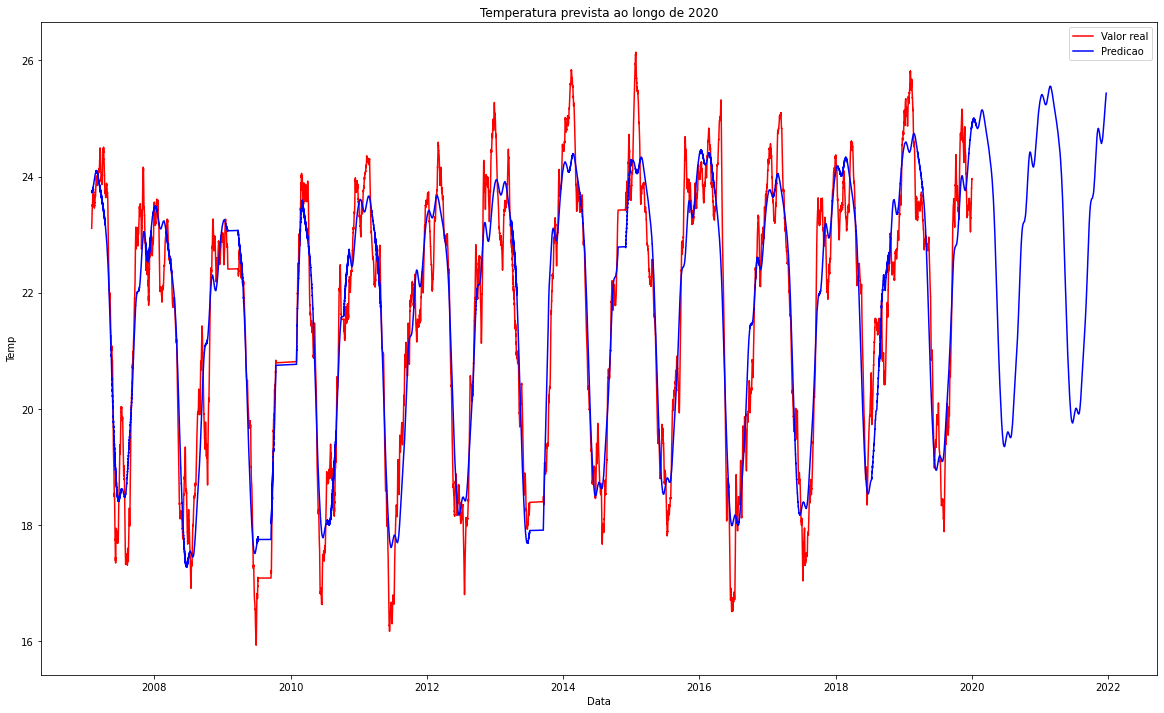

In [33]:
plt.figure(figsize=(20,12))
plt.plot(train.set_index('ds')['y'].rolling(720).mean(), color = 'r', label = 'Valor real')
plt.plot(predFuture.set_index('ds')['yhat'].rolling(720).mean(), color = 'b', label = 'Predicao')
plt.legend()
plt.ylabel('Temp')
plt.xlabel('Data')
plt.title('Temperatura prevista ao longo de 2020')
plt.show()

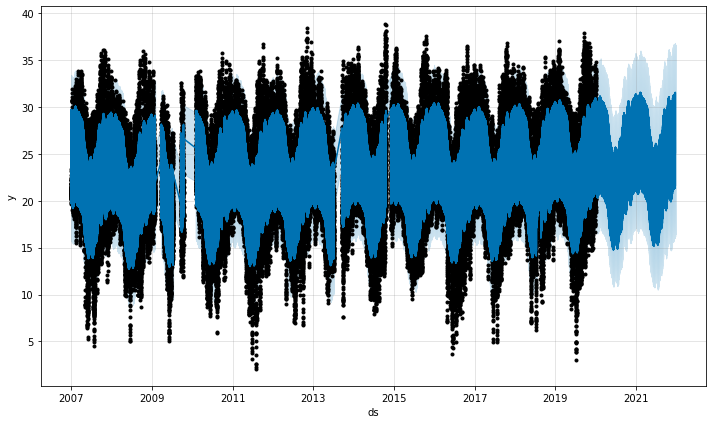

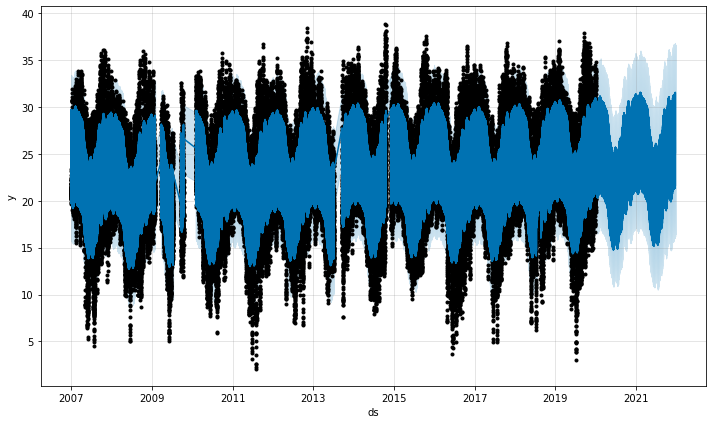

In [37]:
preditor.plot(predFuture)